(keras)=
# Keras Deep Dive

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/tf/02-keras.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**References:**  {cite}`RaschkaMirjalili2019` [[Keras API](https://keras.io/api/)]


## Introduction

Keras provides multiple layers of abstraction to make the implementation of standard architectures very convenient. This allows us to implement custom functionality, such as neural network layers, which is very useful in research projects. The tradeoff with ease of use is that Keras code can be significantly slower due to large overhead. We will also explore how to implement more efficient minimal custom training loops with callbacks.

<br>

In [1]:
import warnings
import random
from pathlib import Path

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, Input

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline


def set_random_seed(seed=0, deterministic=False):
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if deterministic:
        tf.config.experimental.enable_op_determinism()


DATASET_DIR = Path("../data").absolute()
RANDOM_SEED = 42
set_random_seed(seed=RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Models as stacked layers

For stacking layers that perform sequential transforms on input data, we typically use `kr.Sequential()`. Layers can then be added using the `add()` method. 
Alternatively, we can instantiate such the network using `kr.Sequential(layers)` where `layers` is a list of Keras layers.

In [2]:
# Create model
model = kr.Sequential()
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

# Build model
model.build(input_shape=(None, 4))
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


2022-11-24 22:42:22.452875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 22:42:22.453696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Once variables (or model parameters) are created, we can access both
trainable and non-trainable variables as follows:

In [3]:
for v in model.variables:
    print(f'{v.name:20s} {str(v.trainable):7} {v.shape}')

dense/kernel:0       True    (4, 16)
dense/bias:0         True    (16,)
dense_1/kernel:0     True    (16, 32)
dense_1/bias:0       True    (32,)
dense_2/kernel:0     True    (32, 1)
dense_2/bias:0       True    (1,)


## Compiling Keras models

Compiling prepares the model for training via `model.fit()`. Here we can specify a loss function, the optimization algorithm, as well as a list of metrics that will be used to evaluate the model.

```python
model.compile(
    optimizer=kr.optimizers.SGD(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.Precision(),
        kr.metrics.Recall()
    ]
)
```

(02-keras:api-for-cross-entropy)=
### API for cross entropy

Note that cross entropy is a probabilistic loss. And we expect network outputs to be related to class-probabilities. Since softmax activation has worked quite well and is widely used for classification tasks, instead of computing cross entropy directly from probability vectors, some implementations expect **logits** (i.e. softmax preactivation) as inputs to the cross entropy loss function. So you always have to check the docs. 

<br>

**Probabilities.** The default behavior in Keras is `from_logits=False` (not sure why) where the expected network output are class-probabilities in `[0, 1]` over the number of classes that sum to `1.0`. This can come from a `softmax` activation, though any output is allowed as long as the outputs are class distributions. Here the loss function computes `-log q[k*]` where `q` is the output of the network and `k*` is the index of the true class. Predictions of class label can be obtained using `tf.argmax(q)`. 

```python
model = kr.Sequential()
model.add(kr.layers.Dense(512, 'relu'))
model.add(kr.layers.Dense(10, 'softmax')) # class-probabilities

model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss=kr.losses.SparseCategoricalCrossentropy()
)
```

<br>

**Logits.** Setting `from_logits=True` in the cross entropy loss function means that expected outputs of the network are from a dense linear layer. To find class-probabilities for a test input `x`, we use `tf.nn.softmax(model(x))`. Note that we can still use `tf.argmax(s)` on network outputs `s` to predict class labels since softmax is monotonic. Finally, the loss function computes the cross entropy `-log q[k*]` with `q=softmax(s)` for each output-label pair `(s, k*)`.

```python
model = kr.Sequential()
model.add(kr.layers.Dense(512, 'relu'))
model.add(kr.layers.Dense(10)) # logits

model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True)
)
```


<br>

```{figure} https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch15/images/15_11.png
---
name: loss-logits-keras
width: 45em
---

Keras API for loss functions. {cite}`RaschkaMirjalili2019` (Chapter 15)
```

## Solving the XOR problem

**Dataset.** The XOR is the smallest dataset that is not linearly separable (also the most historically interesting relative to its size {cite}`Minsky1969`). Our version of the XOR dataset is generated by adding Gaussian noise to points `(-1, -1)`, `(-1, 1)`, `(1, -1)` and `(1, 1)`. Points generated from `(1, 1)` and `(-1, -1)` will be labeled `1` otherwise `0`. A dataset of size 200 points will be generated with half used for validation.

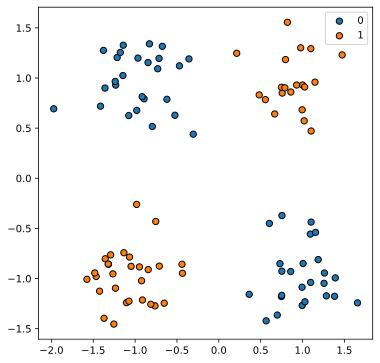

In [4]:
# Create dataset
X = []
Y = []
for p in [(1, 1), (-1, -1), (-1, 1), (1, -1)]:
    x = np.array(p) + np.random.normal(0, 0.3, size=(50, 2)) 
    y = int(p[0] * p[1] > 0) * np.ones(50)
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

# Train-test split
indices = list(range(200))
np.random.shuffle(indices)
valid = indices[:100]
train = indices[100:]
X_valid, y_valid = X[valid, :], Y[valid]
X_train, y_train = X[train, :], Y[train]

# Visualize dataset
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], s=40, edgecolor='black', label=0)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], s=40, edgecolor='black', label=1)
plt.legend();

**Network design.** From the geometry of the dataset, we have to use a network that has at least depth 2, so that the network is not a linear classifier. However, since the dataset is small, we want the network to be not too wide (and not too deep), so the model does not overfit on the dataset.

In [5]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation='tanh'))
model.add(kr.layers.Dense(units=1, activation='sigmoid'))

Keras provides `.summary()` which prints a summary of the network architecture.
Since the number of parameters for the input layer depend on input size , we 
need to specify the dimension of the input. This is done by calling `model.build`
on the expected input shape:

In [6]:
model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


`None` is used as a placeholder for the first dimension of the input to make room for arbitrary batch sizes. Alternatively, we could have set `input_shape` in the input layer so we can skip model build. 

**Model training.** Writing the `train()` function is boilerplate code.
Since the training loop can be complex, developing this each time can
potentially be a source of bugs, not to mention time-consuming. 
TensorFlow Keras API provides a convenient [`.fit()`](https://keras.io/api/models/model_training_apis/#fit-method) method that can be called 
on a compiled model. Observe that this function accepts numpy array as training and validation datasets. In this case, we have to pass batch size which are sampled randomly by default. (Recall that these parameters have to be set if we are to pass `Dataset` objects.)

In [7]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=2, verbose=0
)

2022-11-24 22:42:23.099870: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 22:42:23.436069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 22:42:23.871005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The `fit` method handles the low-level details (regularization, callbacks, metrics, etc.) of training consistently across different implementations. Moreover, this is designed to be performant by exploiting static graph computation. Hence, it is recommended to use `fit` for most use-cases (as well as other built-ins such as `evaluate` and `predict` for inference).

**Results.** The `fit()` method returns a dictionary containing data on how the model trained. We will use this to generate visualizations of the training process. To further evaluate the model, we also look at its decision boundaries. 

In [8]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

4/4 [==============================] - 0s 14ms/step - loss: 0.0403 - binary_accuracy: 0.9900


2022-11-24 22:43:25.796836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   88/11250 [..............................] - ETA: 19s

2022-11-24 22:43:26.092928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11250/11250 [==============================] - 17s 1ms/step


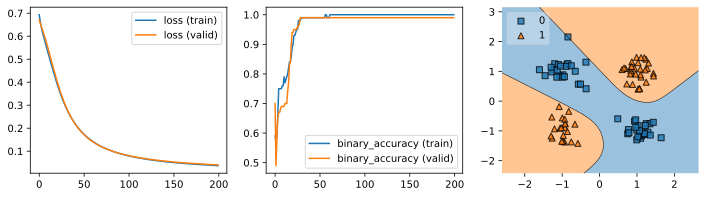

In [9]:
from mlxtend.plotting import plot_decision_regions

def plot_training_history(hist, metric_name):
    _, ax = plt.subplots(1, 3, figsize=(12, 3))

    ax[0].plot(range(200), hist.history['loss'], label='loss (train)')
    ax[0].plot(range(200), hist.history['val_loss'], label='loss (valid)')
    ax[0].legend()

    ax[1].plot(range(200), hist.history[metric_name], label=f'{metric_name} (train)')
    ax[1].plot(range(200), hist.history[f'val_{metric_name}'], label=f'{metric_name} (valid)')
    ax[1].legend();

    ax[2] = plot_decision_regions(X=X_valid, y=y_valid.astype(np.int_), clf=model, legend=2)
    return ax

model.evaluate(X_valid, y_valid)
plot_training_history(hist, 'binary_accuracy');

Prediction probability at each point. Note the blurring at the boundaries:

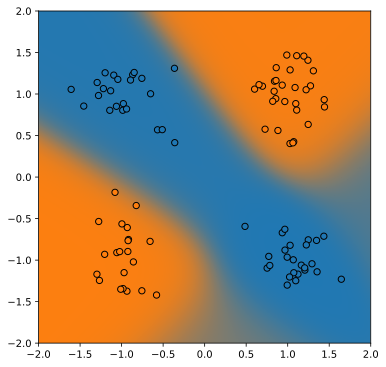

In [10]:
from matplotlib.colors import to_rgba

# Plot valid set points
def plot_decision_gradient(model):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X_valid[y_valid==0, 0], X_valid[y_valid==0, 1], s=40, edgecolor='black', label=0)
    plt.scatter(X_valid[y_valid==1, 0], X_valid[y_valid==1, 1], s=40, edgecolor='black', label=1)

    # Plot decision gradient
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = np.arange(-2, 2, step=0.01)
    x2 = np.arange(-2, 2, step=0.01)

    xx1, xx2 = np.meshgrid(x1, x2)
    model_inputs = np.stack([xx1, xx2], axis=-1)
    preds = model(model_inputs.reshape(-1, 2)).numpy().reshape(400, 400, 1)
    out_img = (1 - preds) * c0 + preds * c1 # blending
    plt.imshow((255 * out_img / out_img.max()).astype(np.uint8), origin='lower', extent=(-2, 2, -2, 2));

# Plotting
plot_decision_gradient(model);

## How to build your models

```{margin}
**Figure 3.1** from
{cite}`ganegedara2022tensorflow`
```

```{figure} ../../img/keras-models.png
---
name: keras-models
width: 670px
---

Sequential, functional, and sub-classing APIs for creating models.
```

### Functional API

Recall that using `Sequential` only allows for a sequence of transformations. This is too restrictive for other architectures. Keras' functional API comes in handy for more complex transformations such as **residual connections**. Observe that the model build adds a new layer called `tf.__operators__.add` under the hood.

In [11]:
# Specify input and output
x = kr.Input(shape=(2,))
f = Dense(units=2, input_shape=(2,), activation='relu')(x)
out = Dense(units=1, activation='sigmoid')(x + f)

# Build model
model = kr.Model(inputs=x, outputs=out)
model.summary() # compile, fit, etc. also works 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 2)           0           ['input_1[0][0]',                
 da)                                                              'dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 1)            3           ['tf.__operators__.add[0][0]'

### Model class

To have fine-grained control when building more complex models, we have to subclass `kr.Model`. This allows us to define `__init__` for initializing model parameters, and the `call` method for defining forward pass. The subclass inherits methods such as `build()`, `compile()`, and `fit()` which means the usual Keras methods work instances of this class.

In [12]:
class MyModel(kr.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(units=4, activation='tanh')
        self.dense2 = Dense(units=1, activation='sigmoid')

    def call(self, x):
        h1 = self.dense1(x)
        out = self.dense2(h1)
        return out


# Build model and model summary
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  12        
                                                                 
 dense_8 (Dense)             multiple                  5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


## Custom Keras layers

Suppose we want to define a new layer that is not already supported by Keras or we want to customize an existing layer. This is done by inheriting from the Keras `Layer` class and defining the `__init__()` and `call()` methods. Optional methods are the `build()` method which handles delayed variable initialization and `get_config()` which can be useful for serialization.

**Implementation.** The following layer computes a linear layer with inputs corrupted with noise at train time, i.e. $\boldsymbol{\mathsf{x}} + \boldsymbol{\epsilon}$ passed to a dense layer. This can be thought of as as a form of regularization. During inference the noise is removed so that it becomes equivalent to a usual dense layer. As usual, we expect the input to be a batch of such vectors $\boldsymbol{\mathsf x}.$ Note that noise is resampled for each input $\boldsymbol{\mathsf x}$ in a batch.

In [13]:
class NoisyLinear(kr.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(
            name='weights', 
            shape=(input_shape[1], self.output_dim),
            initializer='random_normal',
            trainable=True
        )

        self.b = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True
        )
    
    def call(self, x, training=False):
        if training:
            noise = tf.random.normal(
                shape=x.shape, 
                mean=0.0, 
                stddev=self.noise_stddev
            )
        else:
            noise = tf.zeros_like(x)
        
        z = tf.matmul(x + noise, self.w) + self.b
        return kr.activations.relu(z)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "noise_stddev": self.noise_stddev
        })
        return config

Notice that in the `call()` method there is an additional argument, `training=False`. This distinguishes whether a model or layer is used at training or at inference time. This is automatically set in Keras to `True` when using `.fit` and to `False` when using `.predict`. 

Training and inference modes are distinguished because there are operations that behave differently in each setting such as dropout and batch normalization. And in the case of `NoisyLayer`, noise is only added only during training (no noise is added at inference).

In [14]:
noisy_layer = NoisyLinear(output_dim=1)
noisy_layer.build(input_shape=(None, 1))

tf.print(noisy_layer.w)
tf.print(noisy_layer.b)

[[0.0765409]]
[0]


Looking at the noise distribution.

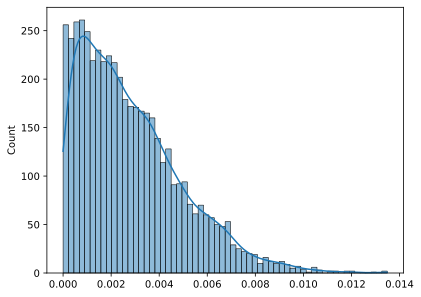

In [15]:
import seaborn as sns

out = noisy_layer(tf.zeros([10000, 1]), training=True)
sns.histplot(out[out > 0].numpy().reshape(-1), bins=60, kde=True);

Testing the `.config` method.

In [16]:
# Re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
print(config)

{'name': 'noisy_linear', 'trainable': True, 'dtype': 'float32', 'output_dim': 1, 'noise_stddev': 0.1}


Testing call outside training if noise is zero:

In [17]:
# Zero noise?
tf.math.reduce_sum(noisy_layer(tf.zeros(shape=(100, 1)))).numpy()

0.0

<br>

**Remodelling.** In this section, we will add `NoisyLinear` to our previous model for XOR. Note that noise should be scaled depending on the magnitude of the input. In our case, the input features vary between $-1$ to $1,$ so we set $\sigma = 0.3$ in the noisy linear for it to have considerable effect.

In [18]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation='tanh'))
model.add(NoisyLinear(output_dim=4, noise_stddev=0.3))
model.add(kr.layers.Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(from_logits=False),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train, # fit accepts numpy arrays
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=2, verbose=0
)

2022-11-24 22:43:53.363702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 22:43:53.866575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   90/11250 [..............................] - ETA: 19s

2022-11-24 22:44:56.187085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11250/11250 [==============================] - 17s 1ms/step


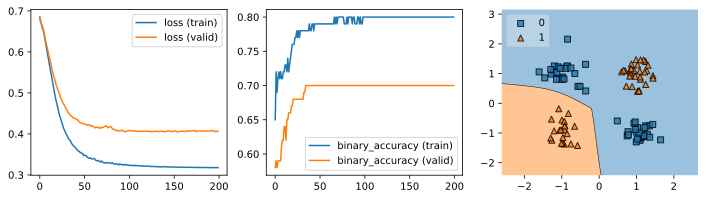

In [20]:
plot_training_history(hist, 'binary_accuracy');

Notice that the training curve is noisier than before since we added a large amount of noise. On the other hand, the validation curves are not noisy at all. This indicates that Keras automatically sets `training` to `False` during evaluation. Also note that while the validation performance is perfect, it seems to generalize worse since the decision boundaries are too sharp.

## Saving and loading models

Models can be saved and loaded as follows. Note that below we save a compiled model, i.e. the model includes a reference to an optimizer. Setting `include_optimizer=True` also saves the learned weights of the optimizer (e.g. moving averages of the gradients).

In [21]:
model.save('model.h5', 
    overwrite=True, 
    include_optimizer=True,
    save_format='h5'
)

Note that custom layers need to be taken particular care of when loading:

In [22]:
model_load = kr.models.load_model(
    'model.h5', 
    custom_objects={'NoisyLinear': NoisyLinear}
)

model_load.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


The network architecture can also be persisted as a JSON object:

In [23]:
import json

json_object = json.loads(model.to_json())
print(json.dumps(json_object, indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential_2",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            2
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "dense_9_input"
        }
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "dense_9",
          "trainable": true,
          "dtype": "float32",
          "units": 4,
          "activation": "tanh",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": null,
          "activity_regularizer": null,
          "kernel_constraint

## Appendix: Keras deep dive

### Metrics

Recall that we specify metrics when compiling models with `model.compile()` where we can pass a list of metrics. Metric values are displayed during `fit()` and logged to the `History` object returned by `fit()`. They are also returned by `model.evaluate()`.

In [24]:
model = kr.Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(units=1)) # logits, i.e. pre-sigmoid

model.compile(
    optimizer='adam',
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.AUC(from_logits=True)
    ]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=60,
    batch_size=2, verbose=0
)

2022-11-24 22:45:16.027753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 22:45:16.602197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [25]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

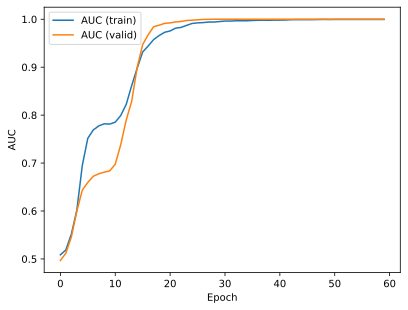

In [26]:
plt.plot(hist.history['auc'], label="AUC (train)")
plt.plot(hist.history['val_auc'], label="AUC (valid)")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend();

#### Metrics are stateful

In [27]:
m = kr.metrics.Accuracy()
m.update_state([0, 1, 1, 1], [1, 1, 1, 1]) # (y_true, y_pred). 3/4
print('Intermediate result:', float(m.result()))

m.update_state([1, 1, 1, 1], [1, 1, 1, 1]) # Update with 4/4 -> 7/8
print('Intermediate result:', float(m.result()))

Intermediate result: 0.75
Intermediate result: 0.875


#### Custom metrics

Keras metrics are stateful and expects `update_state`, `reset_state`, and `result` methods: 

In [28]:
class RootMeanSquaredError(kr.metrics.Metric):
    """Custom metric for computing RMSE."""

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(
            name="mse_sum", 
            initializer="zeros"
        )
        self.total_samples = self.add_weight(
            name="total_samples", 
            initializer="zeros", 
            dtype="int32"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulate statistics for the metric."""

        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)

        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)


    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

Testing this:

In [29]:
rmse = RootMeanSquaredError()
y_true = tf.constant(np.random.randn(32), dtype=tf.float32)
y_pred = tf.constant(np.random.randn(32), dtype=tf.float32)

rmse.update_state(y_true[:16], y_pred[:16])
print('Intermediate RMSE:', float(rmse.result()))

rmse.update_state(y_true[16:], y_pred[16:])
print('Intermediate RMSE:', float(rmse.result()))

Intermediate RMSE: 0.9327664375305176
Intermediate RMSE: 1.2027475833892822


In [30]:
print("Overall RMSE:", tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred)) / len(y_true)).numpy())

Overall RMSE: 1.2027476


### Callbacks API

Callbacks define an [action](https://keras.io/guides/writing_your_own_callbacks/#an-overview-of-callback-methods) on every phase of training, testing, and prediction. Refer to [this guide](https://keras.io/guides/writing_your_own_callbacks) for writing custom callbacks. These are passed as a list on the `callbacks` parameter of the `fit` method of Keras models and the actions are executed accordingly by the Keras API. For example:

```python
checkpoint = kr.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5', # formatted string
    save_best_only=True, 
    monitor='val_accuracy',
    mode='max'
)
```

Note it does not explicitly say when this callback is called. See [docs](https://keras.io/api/callbacks/model_checkpoint/). For custom callbacks, we have to specify the action for each phase:

```python
class MLflowLoggingCallback(kr.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metrics({
            k: logs[k] for k in [
                'loss', 
                'sparse_categorical_accuracy', 
                'val_loss', 
                'val_sparse_categorical_accuracy'
            ]
        })
```


### Training from scratch

Classifiying [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) images:

In [31]:
import time
import tensorflow_datasets as tfds
import tensorflow as tf


def transform_image(img):
    img = tf.image.per_image_standardization(img)
    img = tf.reshape(img, (-1,))
    return img


def get_fmnist_model():
    model = kr.Sequential([
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=10)
    ])
    model.build(input_shape=(None, 784))
    return model


FMNIST, FMNIST_info = tfds.load(
    "fashion_mnist", 
    data_dir="./data", 
    with_info=True, 
    shuffle_files=False
)

train_ds, valid_ds = FMNIST["train"], FMNIST["test"]
f = lambda x: (transform_image(x["image"]), x["label"])
train_ds = train_ds.map(f)
valid_ds = valid_ds.map(f)
print(len(train_ds), len(valid_ds))


def reset_experiment():
    """Reset random seed and data loaders."""
    global train_loader
    global valid_loader

    set_random_seed(RANDOM_SEED, deterministic=False)
    train_loader = train_ds.shuffle(10000).batch(32).prefetch(100)
    valid_loader = valid_ds.batch(32)

60000 10000


#### Train and eval steps

Training has two types of steps per epoch: the `train_step` where the model weights and metrics are updated for a single step of gradient descent for each minibatch, and the `eval_step` which evaluates the metrics over the hold-out dataset at the end of the epoch. Objects which persist throughout the training process such as loss functions, metrics, and optimizer are defined in the outer scope.

In [32]:
loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = kr.optimizers.SGD()

# List of metrics to track + accumulator for loss (type: metric)
metrics = [kr.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = kr.metrics.Mean(name='loss')

# For consistency, same for validation
val_metrics = [kr.metrics.SparseCategoricalAccuracy()]
val_loss_tracking_metric = kr.metrics.Mean(name='loss')

# Insert loss accumulator as first metric
train_metrics = [loss_tracking_metric] + metrics
eval_metrics  = [val_loss_tracking_metric] + val_metrics


def train_step(input, target, model):
    """Single weight update of neural network in TRAIN mode."""

    # Track gradients -> backprop -> update weights
    with tf.GradientTape() as tape:
        output = model(input, training=True) # !
        loss = loss_fn(target, output)
    
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Update metrics
    loss_tracking_metric.update_state(loss)
    for m in metrics:
        m.update_state(target, output)


def eval_step(input, target, model):
    """Evaluate outputs of neural network."""

    # Make forward pass
    output = model(input, training=False) # !
    loss = loss_fn(target, output)

    # Update metrics
    val_loss_tracking_metric.update_state(loss)
    for m in val_metrics:
        m.update_state(target, output)

<br>

**Training loop**. Note that we want per-epoch averages (not averages since the start of training), thus we reset the metrics at the start of each epoch. The metrics for training compute moving averages over mini-batches. This behavior can be modified using the `reduction` parameter of the loss function.

In [33]:
def reset_metrics():
    for m in train_metrics + eval_metrics:
        m.reset_state()


def custom_train(
    x, 
    validation_data, 
    epochs, 
    model, 
    train_step, 
    eval_step, 
    verbose=0
):
    """Custom trainer for Keras models."""

    train_loader = x
    X_valid, y_valid = next(iter(validation_data))

    for epoch in range(epochs):
        reset_metrics()
        
        # Update metrics for each weight update
        for batch in train_loader:
            X_batch, y_batch = batch
            train_step(X_batch, y_batch, model)
        
        # Update metrics once after each epoch
        eval_step(X_valid, y_valid, model)

        # Print final metrics
        if verbose:  
            print(f"Results at end of epoch {epoch}:")
            for m in train_metrics:
                print(f"  {m.name}: {m.result():.4f}")
            for m in eval_metrics:
                print(f"  val_{m.name}: {m.result():.4f}")
            print()
    
    return model

Timing training over three epochs:

In [34]:
train_times = {}

reset_experiment()

start_time = time.time()
custom_train(
    train_loader,
    epochs=3,
    validation_data=valid_loader,
    model=get_fmnist_model(),
    verbose=1,
    train_step=train_step,
    eval_step=eval_step
)
train_times['Train loop\n(eager)'] = time.time() - start_time

2022-11-24 22:45:49.636992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Results at end of epoch 0:
  loss: 0.5250
  sparse_categorical_accuracy: 0.8124
  val_loss: 0.3169
  val_sparse_categorical_accuracy: 0.8750

Results at end of epoch 1:
  loss: 0.3759
  sparse_categorical_accuracy: 0.8639
  val_loss: 0.2233
  val_sparse_categorical_accuracy: 0.9375

Results at end of epoch 2:
  loss: 0.3373
  sparse_categorical_accuracy: 0.8769
  val_loss: 0.2024
  val_sparse_categorical_accuracy: 0.9375



#### Static graph execution

This is the same training loop as above but with `train_step` and `test_step` compiled as static graphs with `tf.function`. Testing whether this has significant speedup over the eager version:

In [35]:
reset_experiment()

start_time = time.time()
custom_train(
    train_loader,
    epochs=3, 
    validation_data=valid_loader,
    model=get_fmnist_model(),
    verbose=1,
    train_step=tf.function(train_step),
    eval_step=tf.function(eval_step)
)
train_times['Train loop\n(static)'] = time.time() - start_time

2022-11-24 22:46:43.778512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-24 22:46:44.032321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 22:46:49.886821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Results at end of epoch 0:
  loss: 0.5250
  sparse_categorical_accuracy: 0.8124
  val_loss: 0.3169
  val_sparse_categorical_accuracy: 0.8750

Results at end of epoch 1:
  loss: 0.3759
  sparse_categorical_accuracy: 0.8639
  val_loss: 0.2233
  val_sparse_categorical_accuracy: 0.9375

Results at end of epoch 2:
  loss: 0.3373
  sparse_categorical_accuracy: 0.8769
  val_loss: 0.2024
  val_sparse_categorical_accuracy: 0.9375



#### Customizing the `fit()` function

In the following model, we extend the `train_step` and `test_step` method of the `Model` base class. These methods are accessed by the `fit()` method that the Keras model inherits. There are only two differences from the previous code: (1) the `metrics` attribute has a tracker for the average loss, so we no longer need to treat this as a separate case, and (2) applying `update_state` on compiled metrics updates all in one step, so there is no need to iterate over them.

In [36]:
class CustomModel(kr.Model):
    def __init__(self):
        super().__init__(self)
        self.model = get_fmnist_model()
    
    def call(self, x, training=False):
        return self.model(x)

    def train_step(self, data):
        inputs, targets = data
        
        with tf.GradientTape() as tape:
            preds = self.call(inputs, training=True)
            loss = self.compiled_loss(targets, preds)
        
        # Update states
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, preds)
        
        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs

    def test_step(self, data):
        inputs, targets = data
        preds = self.call(inputs, training=False)

        # Update states
        self.compiled_loss(targets, preds)
        self.compiled_metrics.update_state(targets, preds)

        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


def keras_fit(model, x, validation_data,  epochs=3):
    """Train model using Keras fit method."""

    model.build(input_shape=(None, 784))
    model.compile(
        optimizer=kr.optimizers.SGD(), 
        loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=[kr.metrics.SparseCategoricalAccuracy()]
    )
    
    model.fit(x,
        epochs=epochs,
        validation_data=validation_data
    )


# Timing training run with fit function
reset_experiment()

start = time.time()
model = CustomModel()
keras_fit(model, train_loader, valid_loader, epochs=3)
train_times["Keras fit\n(custom)"] = time.time() - start

Epoch 1/3
   1/1875 [..............................] - ETA: 10:11 - loss: 2.3384 - sparse_categorical_accuracy: 0.1250

2022-11-24 22:47:01.859891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1867/1875 [============================>.] - ETA: 0s - loss: 0.5250 - sparse_categorical_accuracy: 0.8115

2022-11-24 22:47:12.254287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8117 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8429
Epoch 2/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.4011 - val_sparse_categorical_accuracy: 0.8529
Epoch 3/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8649


If we look at the execution times for three epochs, we see that the custom training loop with static `train_step` and `test_step` functions has the fastest execution time. This makes sense since Keras `fit` must be doing all sorts of stuff under the hood. Both methods have performance gains over custom loop with train and evaluation steps in eager execution.

Max execution time: 54.02480220794678 sec.


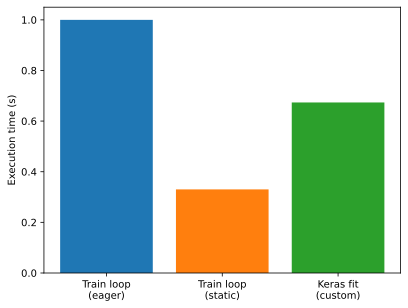

In [37]:
plt.bar(train_times.keys(), np.array(list(train_times.values())) / max(train_times.values()), color=['C0', 'C1', 'C2'])
plt.ylabel('Execution time (s)');
print(f"Max execution time: {max(train_times.values())} sec.")

**Remark.** Note that this speedup factor is particular to the layers used and whether or not `enable_op_determinism()` is turned on. In this notebook, we turned off op determinism since this is what is relevant in practice.

### Regularization

Layers can be configured using optional arguments to choose the type regularization to use.
Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. For Keras, regularization penalties are applied on a per-layer basis. Forward layers such as `Dense` exposes three keyword arguments which are self-explanatory:

* `kernel_regularizer`
* `bias_regularizer`
* `activity_regularizer` (outputs)

#### Keras fit method

Keras makes it easy to add regularization to our models:

In [38]:
import tensorflow.keras.regularizers as regularizers
reset_experiment()

model = kr.Sequential()
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=10))

keras_fit(model, train_loader, valid_loader, epochs=3)

Epoch 1/3


2022-11-24 22:47:38.577476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 1.4004 - sparse_categorical_accuracy: 0.8110

2022-11-24 22:47:58.035529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 22s 11ms/step - loss: 1.3999 - sparse_categorical_accuracy: 0.8111 - val_loss: 1.2845 - val_sparse_categorical_accuracy: 0.8418
Epoch 2/3
1875/1875 [==============================] - 20s 11ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.8622 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.8517
Epoch 3/3
1875/1875 [==============================] - 22s 12ms/step - loss: 1.1060 - sparse_categorical_accuracy: 0.8753 - val_loss: 1.1184 - val_sparse_categorical_accuracy: 0.8644


Here we train the same network as above. You can test by setting the regularization parameter to zero that this reproduces the above results. Since we have different results, this means that the `fit` method automatically takes into account the regularization terms during backpropagation without any further setting.

#### Custom training

For custom training loops, we have to account for weight regularization before performing backpropagation. This can be implemented by specifying the type of regularization when initializing each Keras layer and adding `sum(self.losses)` to the loss function to backpropagate these contributions to the weights. See also the [`add_loss()`](https://keras.io/api/losses/#the-addloss-api) method for custom layers. 

In [39]:
class RegularizedModel(tf.keras.Model):
    def __init__(self, param=0.0):
        super().__init__(self)
        self.h0 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h1 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h2 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h3 = Dense(10)
    
    def call(self, x, training=False):
        return self.h3(self.h2(self.h1(self.h0(x))))

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            preds = self.call(inputs, training=True)
            loss = self.compiled_loss(targets, preds) + sum(self.losses)   # (!)
        
        # Update states
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, preds)
        
        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs

    def test_step(self, data):
        inputs, targets = data
        preds = self.call(inputs, training=False)

        # Update states
        self.compiled_loss(targets, preds)
        self.compiled_metrics.update_state(targets, preds)

        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


# Construct and compile an instance of CustomModel
reset_experiment()
model = RegularizedModel(param=1e-3)
keras_fit(model, train_loader, valid_loader, epochs=3)

Epoch 1/3


2022-11-24 22:48:43.430624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1869/1875 [============================>.] - ETA: 0s - loss: 0.5265 - sparse_categorical_accuracy: 0.8110

2022-11-24 22:48:54.411496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 0.5260 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.4391 - val_sparse_categorical_accuracy: 0.8418
Epoch 2/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.4034 - val_sparse_categorical_accuracy: 0.8517
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3420 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.3798 - val_sparse_categorical_accuracy: 0.8644


Notice that the results for the `fit` method are reproduced except for the loss value which corresponds only to the cross entropy. This is because the loss only includes the compiled loss. Though logging regularization penalty seems to be less useful, to be totally consistent with Keras `fit` use:

```python
loss = self.compiled_loss(targets, preds, regularization_losses=self.losses)
```

## Appendix: Autoencoders

This section demonstrates how easy it is to test research ideas in Keras. We implement an **autoencoder** which learns the identity function in an unsupervised way by using the same inputs as a target. The characteristic **encoder**-**decoder** architecture of autoencoders essentially accomplishes dimensionality reduction to an intermediate representation called the **bottleneck**. Here the encoder transforms the input into a lower-dimensional representation, and the decoder learns to transform this back to the original input with the least amount of distortion.

```{figure} ../../img/denoising-autoencoder-architecture.png
---
width: 40em
---
Illustration of the denoising autoencoder model architecture. {cite}`weng2018VAE`
```

This unsupervised process allows us to discover a more efficient and compressed representation of the data in a sample efficient manner. Downstream tasks such as computing vector similarity can take advantage of this compressed representation. The model architecture is quickly implemented using sequential dense layers in Keras:

In [40]:
model = kr.Sequential([
    Dense(64,  activation='relu', input_shape=(784,)),
    Dense(32,  activation='relu'),
    Dense(64,  activation='relu'),
    Dense(784, activation='tanh')
])

Our task will be to denoise images, so this model is called a **denoising autoencoder**. The model gathers evidence from other examples where pixels in the same regions are not masked. This works fairly well with image datasets since there is high redundancy with the input data.

### MNIST + noise

Preprocessing to `[-1, 1]` which is the output range of the tanh function. As shown in the above figure, we will randomly mask pixels in the input images. The corresponding unmasked images will be used as target.

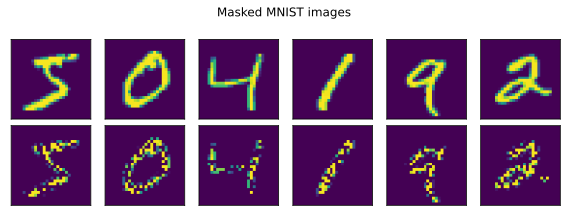

In [41]:
from tensorflow.keras.datasets import mnist

def preprocess(x):
    x = (x - 128.0) / 128.0
    x = x.reshape(-1, 784)
    return x

def generate_masked_inputs(x, p):
    mask = np.random.binomial(n=1, p=p, size=x.shape).astype('float32')
    return x * mask


(x_train, y_train), (x_test, y_test) = mnist.load_data()
noisy_x_train = preprocess(generate_masked_inputs(x_train, p=0.5))
noisy_x_test  = preprocess(generate_masked_inputs(x_test,  p=0.5))
x_train = preprocess(x_train)
x_test  = preprocess(x_test)

# Plotting
fig, ax = plt.subplots(2, 6, figsize=(8, 3))
for i in range(6):
    ax[(0, i)].set_title(f"{y_train[i]}", fontsize=10)
    ax[(0, i)].imshow(x_train[i].reshape(28, 28), interpolation='nearest')
    ax[(0, i)].set_xticks([])
    ax[(0, i)].set_yticks([])
    ax[(0, i)].set_title("", fontsize=10)
    ax[(1, i)].imshow(noisy_x_train[i].reshape(28, 28), interpolation='nearest');
    ax[(1, i)].set_xticks([])
    ax[(1, i)].set_yticks([])

fig.suptitle("Masked MNIST images")
fig.tight_layout()

### Training with MSE loss

In [42]:
model.compile(optimizer='adam', loss='mse')

hist = model.fit(
    x=noisy_x_train, y=x_train,
    validation_data=(noisy_x_test, x_test),
    epochs=40, 
    batch_size=32, 
    verbose=False
)

2022-11-24 22:49:21.633787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 22:49:28.531558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


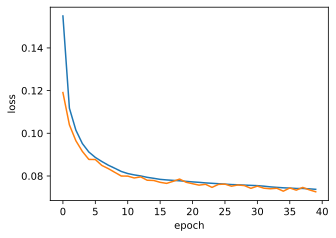

In [43]:
# Plot train loss
plt.figure(figsize=(5, 3.5))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.ylabel('loss')
plt.xlabel('epoch');

The train and test loss curves are fairly identical. This tells us that the autoencoder is not overfitting and that the train and test distributions are statistically equivalent.

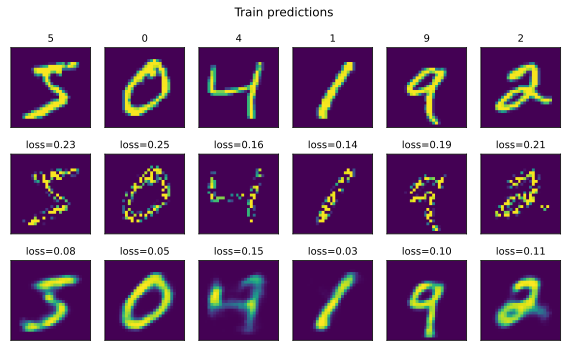

MSE train (noise): 0.222
MSE train (preds): 0.072


In [44]:
def process_axis(ax, i, j, img_vec, title):
    ax[(i, j)].set_title(title, fontsize=10)
    ax[(i, j)].imshow(img_vec.reshape(28, 28), interpolation='nearest')
    ax[(i, j)].set_xticks([])
    ax[(i, j)].set_yticks([])

preds = model(noisy_x_train).numpy()

fig, ax = plt.subplots(3, 6, figsize=(8, 5))
for j in range(6):
    process_axis(ax, 0, j, x_train[j], y_train[j])
    process_axis(ax, 1, j, noisy_x_train[j], f"loss={((x_train[j]-noisy_x_train[j])**2).mean():.2f}")
    process_axis(ax, 2, j, preds[j], f"loss={((x_train[j]-preds[j])**2).mean():.2f}")

fig.suptitle("Train predictions")
fig.tight_layout()
plt.show()

print(f"MSE train (noise): {((noisy_x_train - x_train)**2).mean():.3f}")
print(f"MSE train (preds): {((preds         - x_train)**2).mean():.3f}")

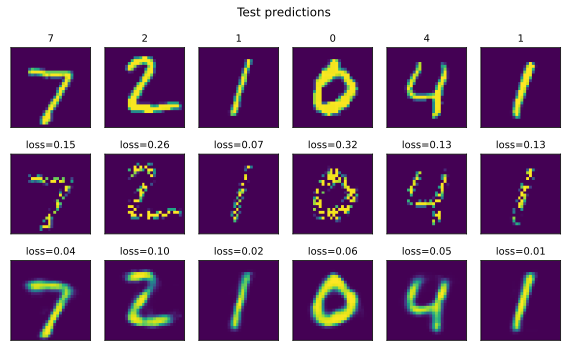

MSE test (noise): 0.226
MSE test (preds): 0.073


In [45]:
preds = model(noisy_x_test).numpy()

fig, ax = plt.subplots(3, 6, figsize=(8, 5))
for j in range(6):
    process_axis(ax, 0, j, x_test[j], y_test[j])
    process_axis(ax, 1, j, noisy_x_test[j], f"loss={((x_test[j]-noisy_x_test[j])**2).mean():.2f}")
    process_axis(ax, 2, j, preds[j], f"loss={((x_test[j]-preds[j])**2).mean():.2f}")

fig.suptitle("Test predictions")
fig.tight_layout()
plt.show()

print(f"MSE test (noise): {((noisy_x_test - x_test)**2).mean():.3f}")
print(f"MSE test (preds): {((preds        - x_test)**2).mean():.3f}")